In [16]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [111]:
emitStr = '14'
emit = float(emitStr)*1.0e-9
n_particles = 80000

NL_t = 0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

Me = impact.util.Me
ke = 100*1.0e6
energy = ke+Me
freq = 30*1.0e6
offset = 0.0003

Espread = 9.0e-5
g = energy/Me
bg = np.sqrt(g**2-1.0)
emitN = emit*bg
print(g,emitN,Espread*energy)

turns = int(100/np.sqrt(emitN))
print(turns)

196.69513367455127 2.7536962831446975e-06 9045.9899019
32768


# Prepare Beam

In [18]:
alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

In [19]:
beam = impact.getBeam()
beam.current = 0.0
beam.kinetic_energy = ke
beam.mass = Me
beam.charge = -1.0
beam.frequency = freq
beam.nCore_y = 8
beam.nCore_z = 4
beam.n_particles = n_particles

In [20]:
beam.distribution.distribution_type = 'Gauss'
beam.distribution.betx  = betaEntrance
beam.distribution.alfx  = alfaEntrance
beam.distribution.emitx = emitN
beam.distribution.bety  = betaEntrance
beam.distribution.alfy  = alfaEntrance
beam.distribution.emity = emitN
beam.distribution.betz  = 200
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (Espread*energy*1.0e-6)**2*beam.distribution.betz

In [21]:
beam.mesh.fld_solver = 'Symplectic_Spectral_2D'

# Prepare Lattice

In [22]:
lattice = [impact.getElem('loop_through_lattice'),impact.getElem('nonlinear_insert'),impact.getElem('linear_matrix_map')] 
lattice[0].turns=turns
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_mu
lattice[1].n_sckick = 100
lattice[2].nonlinear_insert_length = NL_L
lattice[2].nonlinear_insert_tuneAdvance = NL_mu

testLat = [copy(lattice[0])]
testLat[0].turns=0

In [9]:
impact.writeInputFile(beam,testLat)
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

In [10]:
pDataInit = impact.readParticleData(-111110,ke,Me,freq)
pDataInit[:,0] = pDataInit[:,0] + offset
npt2=int(n_particles/20)
pDataInit[:npt2,0] = offset + np.sqrt(emitN)*(0.2+0.02*np.random.randn(npt2))

1.8177272012675272 9091.34606532583


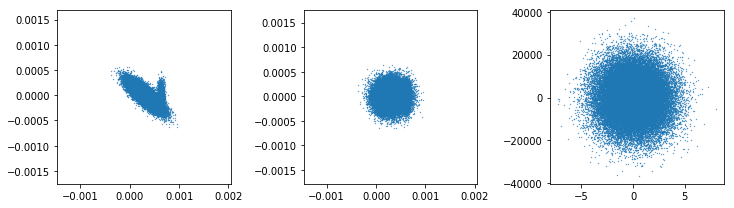

In [11]:
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pDataInit[:,0],pDataInit[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pDataInit[:,0],pDataInit[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pDataInit[:,4],pDataInit[:,5],s=0.1)
plt.tight_layout()
print(np.std(pDataInit[:,4]),np.std(pDataInit[:,5]))

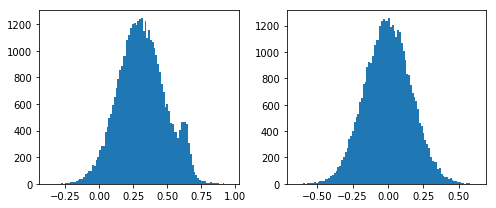

In [12]:
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.hist(pDataInit[:,0]*1.0e3,bins=100)
plt.subplot(1,2,2)
plt.hist(pDataInit[:,2]*1.0e3,bins=100)
plt.tight_layout()
plt.savefig('profile.png',dpi=180)

In [13]:
impact.writeParticleData(pDataInit,ke,Me,freq)
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,lattice)
impact.run(beam)

0

In [86]:
fort82=np.loadtxt('fort.82')
X = fort82[:,1] + 1j*fort82[:,2]
np.save('X.mid.emit'+emitStr+'nm',X)
print('X.mid.shape',X.shape)

X.mid.shape (6026,)


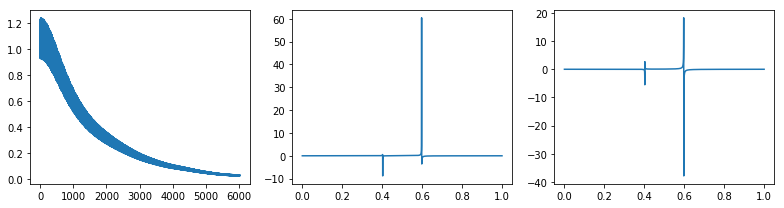

In [87]:
tune = np.linspace(0,1,len(X))
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.plot(np.abs(X)/np.abs(X[0]))
plt.subplot(1,3,2)
plt.plot(tune,np.real(np.fft.fft(X)))
plt.subplot(1,3,3)
plt.plot(tune,np.imag(np.fft.fft(X)))
plt.tight_layout()
plt.savefig('decoherence.png',dpi=180)

In [88]:
L=0.0
for item in lattice:
    if 'length' in item.keys():
        L = L + item.length

In [89]:
X=impact.readRMS('x')        
N=np.argwhere((np.mod(X.s,L)<1.0e-4) | (np.mod(X.s,L) > L-1.0e-4))
N=N[:,0]
M=[]
z = 0.0
for i in range(len(N)):
    if z < X.s[N[i]]:
        M.append(N[i-1])
        z = X.s[N[i]]    
M=np.array(M)

Px = X.centroid_x[M]*alfaEntrance/np.sqrt(betaEntrance)/NL_c + X.centroid_px[M]*np.sqrt(betaEntrance)/NL_c
X  = X.centroid_x[M]/np.sqrt(betaEntrance)/NL_c
X = X + 1j*Px

In [90]:
np.save('X.ent.emit'+emitStr+'nm',X)
print('X.ent.shape',X.shape)

X.ent.shape (6026,)
